# Reconocimento de horas en relos analógico

Se utiliza el [dataset de relojes de Kaggles](https://www.kaggle.com/datasets/gpiosenka/time-image-datasetclassification) para entrenar un modelo de reconocimiento de horas en relojes analógicos.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import pandas as pd
import zipfile
import numpy as np
import os


Semilla inicial para mostrar siempre las mismas imagenes

In [2]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

Método para mostrar la imagen que carga en BGR y la convierte a RGB

In [3]:
def imshow(pImage):
    plt.imshow(cv2.cvtColor(pImage.astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.axis('off')

## Decompresión de imágenes

Descomprimir dataset para trabajar con ello. Estos ficheros no se subiran al github

In [4]:
local_zip = './tmp/archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./Assets/dataset')
zip_ref.close()

## Lectura de datos

### Lectura fichero csv

In [5]:
root_dir = './Assets/dataset'
csv_data = pd.read_csv(os.path.join(root_dir,'clocks.csv'))

Creamos un dicionario que a traves de la clase se puede sacar la hora para utilizarlos en la visualización de imagenes

In [6]:
hours_dict = pd.Series(csv_data['labels'].values, index=csv_data['class index']).to_dict()

Divide los datos en 3 variables dependiendo si son datos de entrenamiento, test o de validación

In [7]:
train_data = csv_data[csv_data['data set'] == "train"]
test_data = csv_data[csv_data['data set'] == "test"]
valid_data = csv_data[csv_data['data set'] == "valid"]

Crea variables con solo las labels y las direcciones de las imagenes para el entrenamiento

In [8]:
train_labels = train_data['class index'].values
test_labels = test_data['class index'].values
valid_labels = valid_data['class index'].values

train_images_dir = train_data['filepaths'].values
test_images_dir = test_data['filepaths'].values
valid_images_dir = valid_data['filepaths'].values

In [9]:
print("Train shape", train_labels.shape)
print("Test shape", test_labels.shape)
print("Valid shape", valid_labels.shape)

Train shape (11520,)
Test shape (1440,)
Valid shape (1440,)


In [10]:
print("Class types", len(np.unique(train_labels)))

Class types 144


### Mostrar imagenes aleatorias

Muestra 18 imagenes aleatorias en 3 filas con su etiqueta de hora abajo

[ 7270   860  5390  5191 11284  5734  6265   466  4426  5578 11363 11111
  8322  1685   769 10583  6949  2433]


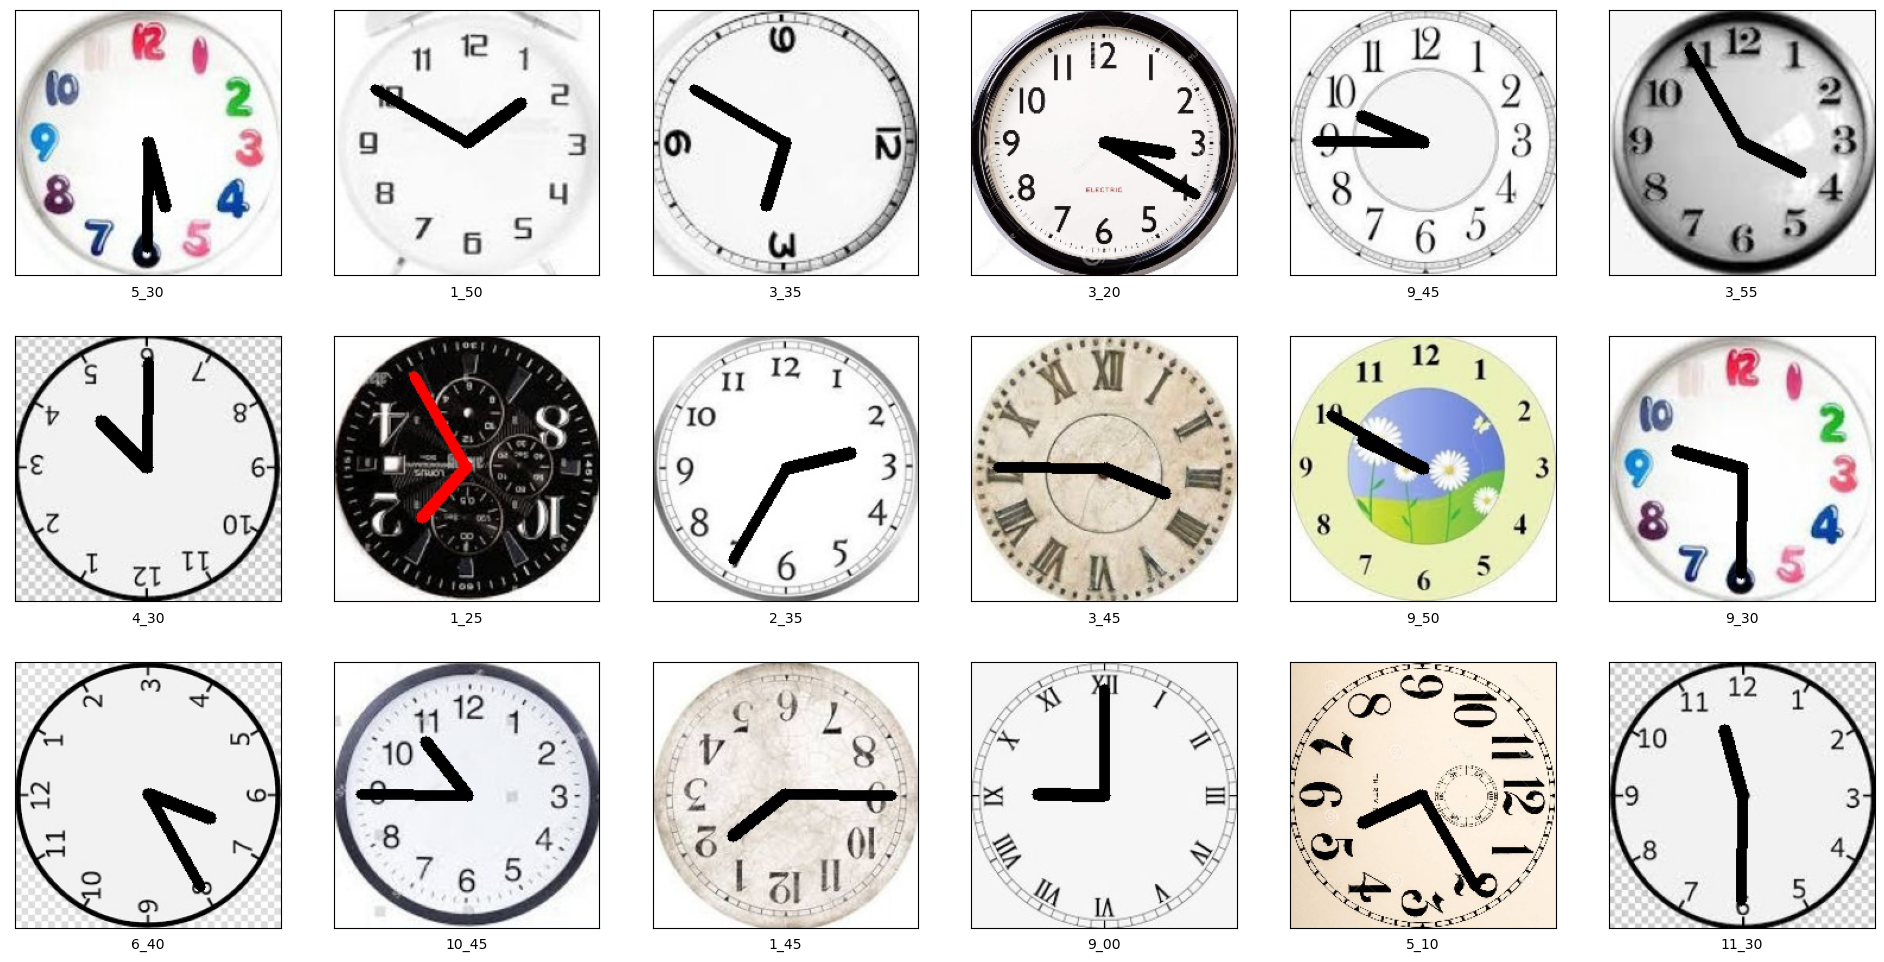

In [11]:
nrows = 3
ncols = 6



fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

idx = np.random.randint(0, len(train_images_dir), size=(nrows * ncols))

labels_filepaths = csv_data.loc[idx, ['labels','filepaths']].values
labels = csv_data.loc[idx, ['labels']].values
filepaths = csv_data.loc[idx, ['filepaths']].values
# next_images = csv_data['filepaths'].sample(n=nrows * ncols).values
print(idx)

for i, label in enumerate(labels):
  # coge el ndarray correcto y el elemento 0 ya que solo tiene ese valor
  img_path = filepaths[i][0]
  full_img_path = root_dir + "/" + img_path

  sp = plt.subplot(nrows, ncols, i + 1)
  plt.xticks([])
  plt.yticks([]) 
  plt.grid(False)

  img = mpimg.imread(full_img_path)
  plt.imshow(img)
  plt.xlabel(label[0])

plt.show()

### Cargar las imagenes en memoria

En cada tipo de datos crea una lista con las direcciones relativas desde la raiz del proyecto y luego carga en un array las imagenes mediante la libreria cv2

In [12]:
train_images_full_dir = [root_dir + "/" +  fname for fname in train_images_dir]
train_images = np.array([cv2.imread(fname, ) for fname in train_images_full_dir])

test_images_full_dir = [root_dir + "/" +  fname for fname in test_images_dir]
test_images = np.array([cv2.imread(fname, ) for fname in test_images_full_dir])

valid_images_full_dir = [root_dir + "/" +  fname for fname in valid_images_dir]
valid_images = np.array([cv2.imread(fname, ) for fname in valid_images_full_dir])

In [13]:
print("Image shape", train_images[0].shape)

Image shape (224, 224, 3)


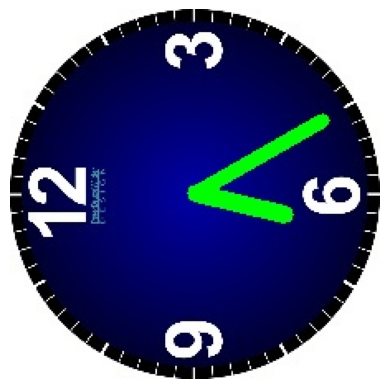

In [14]:
imshow(train_images[8154])

## Procesamiento de datos

Esta red convoluccional está inspirada en lo que hicimos en la libreta CNNsCIFAR con ciertas mejorar para que de una accuracy bastante alta y entienda el nuevo tipo de datos

In [37]:
model = tf.keras.Sequential([
tf.keras.layers.Input(shape=(224, 224, 3)),
tf.keras.layers.Rescaling(1./255),
tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
tf.keras.layers.MaxPooling2D(pool_size=2),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
tf.keras.layers.MaxPooling2D(pool_size=2),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dense(144, activation='softmax')
])


In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 112, 112, 128)    

Pone de nuevo la semilla luego poder ir probando con otros modelos o con otras semillas

In [39]:
np.random.seed(seed)
tf.random.set_seed(seed)

In [40]:
# Optimizadores que hemos utilizado tras probar con el adam y otros

model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])


epochs = 5


history = model.fit(x= train_images, y=train_labels, epochs=epochs, batch_size=8, validation_data=(test_images, test_labels))



InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [19]:
print("Train score:", model.evaluate(train_images, train_labels))
print("Test score:", model.evaluate(test_images, test_labels))
print("Valid score:", model.evaluate(valid_images, valid_labels))

360/360 [==============================] - 5s 14ms/step - loss: 0.0221 - accuracy: 0.9982
Train score: [0.022074656561017036, 0.9981771111488342]
45/45 [==============================] - 1s 14ms/step - loss: 0.0554 - accuracy: 0.9937
Test score: [0.055376358330249786, 0.9937499761581421]
45/45 [==============================] - 1s 14ms/step - loss: 0.0310 - accuracy: 0.9958
Valid score: [0.030951041728258133, 0.9958333373069763]


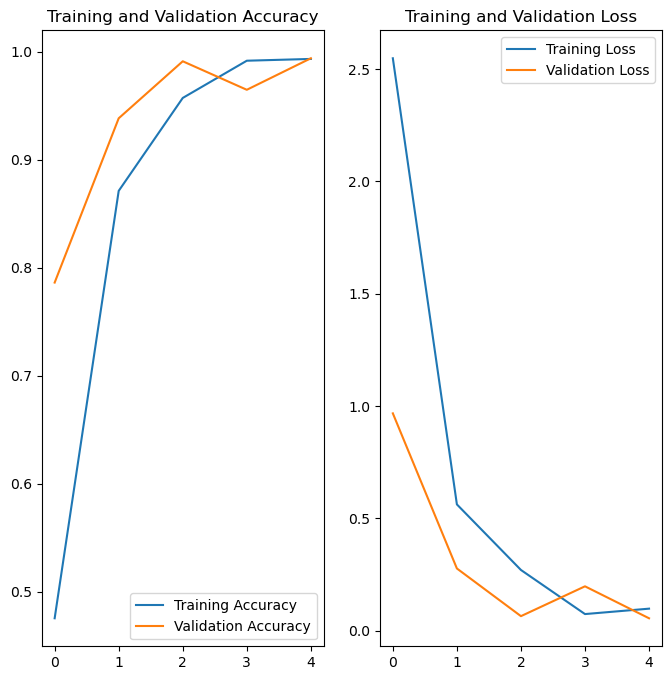

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Pruebas

saca otras 18 imagenes mostrando en verde las que ha acertado y en rojo las que no con su hora real y la hora predicha

[12646 12380 12814 12650 12615 12564 11641 11986 12758 11850 11607 12916
 12643 12391 11650 12852 12289 11863]


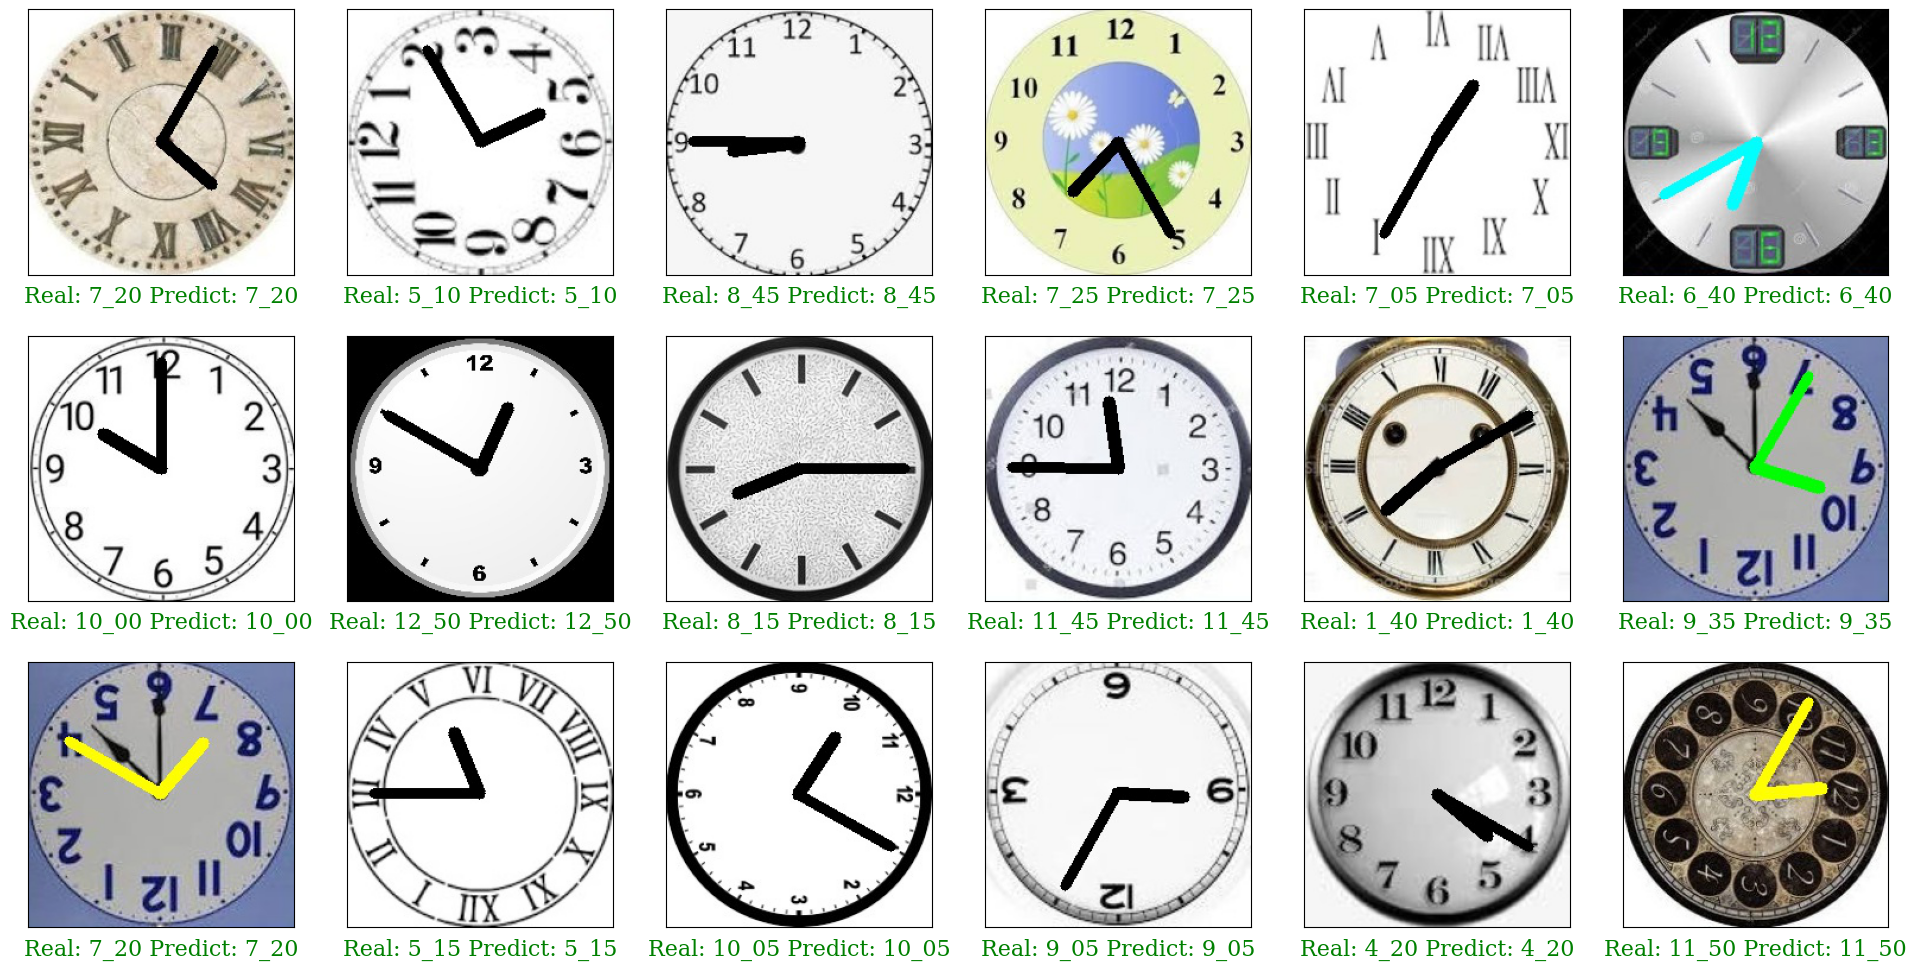

In [21]:
nrows = 3
ncols = 6


fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

size = nrows * ncols

idx = np.random.randint(len(train_images_dir), len(
    test_images_dir) + len(train_images_dir), size=size)
    
labels = test_data.loc[idx, ['labels']].values
filepaths = test_data.loc[idx, ['filepaths']].values
# next_images = csv_data['filepaths'].sample(n=nrows * ncols).values
print(idx)


font_valid = {'family': 'serif',
              'color':  'green',
              'weight': 'normal',
              'size': 16,
              }

font_error = {'family': 'serif',
              'color':  'red',
              'weight': 'normal',
              'size': 16,
              }

for i, label in enumerate(labels):
    # coge el ndarray correcto y el elemento 0 ya que solo tiene ese valor
    img_path = filepaths[i][0]
    full_img_path = os.path.join(root_dir, img_path)

    id = idx[i] - len(train_images_dir)
    res = model.predict(test_images[id:(id+1)]).argmax(axis=1)[0]
    prediction_hour = hours_dict[res]

    sp = plt.subplot(nrows, ncols, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)


    font = {}
    if (prediction_hour == label[0]):
        font = font_valid
    else:
        font = font_error
        print("Uno está mal!!!!")

    img = mpimg.imread(full_img_path)
    plt.imshow(img)
    plt.xlabel("Real: " + label[0] + " Predict: " + prediction_hour, font)

plt.show()


Muestra hasta 18 relojes erroneos probando hasta 1000 intentos 

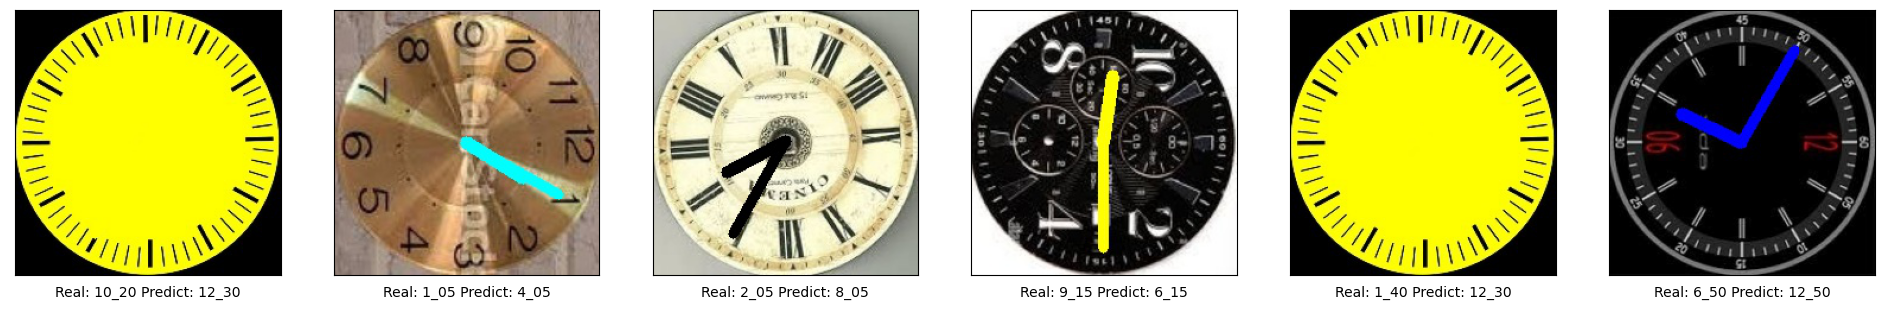

In [22]:
nrows = 3
ncols = 6

size = nrows * ncols

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)


labels = test_data['labels'].values
filepaths = test_data['filepaths'].values


images_shown = 0
indexes_used = []

iter = 0
max_iters = 1000

while images_shown < size and iter < max_iters:

    id = np.random.randint(0, len(test_images_dir))

    label = labels[id]
    img_path = filepaths[id]
    full_img_path = root_dir + "/" + img_path

    res = model.predict(test_images[id:(id+1)]).argmax(axis=1)[0]
    prediction_hour = hours_dict[res]

    iter += 1

    if (prediction_hour == label or id in indexes_used):
        continue

    images_shown += 1

    indexes_used.append(id)
    # Dibujar

    sp = plt.subplot(nrows, ncols, images_shown)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img = mpimg.imread(full_img_path)
    plt.imshow(img)
    plt.xlabel("Real: " + label + " Predict: " + prediction_hour)

plt.show()


### Probar con imagenes reales (cargar)

In [23]:
real_data_dir = 'Assets/external_images'
real_csv = pd.read_csv(os.path.join(real_data_dir,'relojes_reales.csv'))

In [24]:
real_labels = real_csv['class index'].values

real_images_dir = real_csv['filepaths'].values

In [25]:
real_images_full_dir = [real_data_dir + "/" +  fname for fname in real_images_dir]
real_images = np.array([cv2.imread(fname, ) for fname in real_images_full_dir])

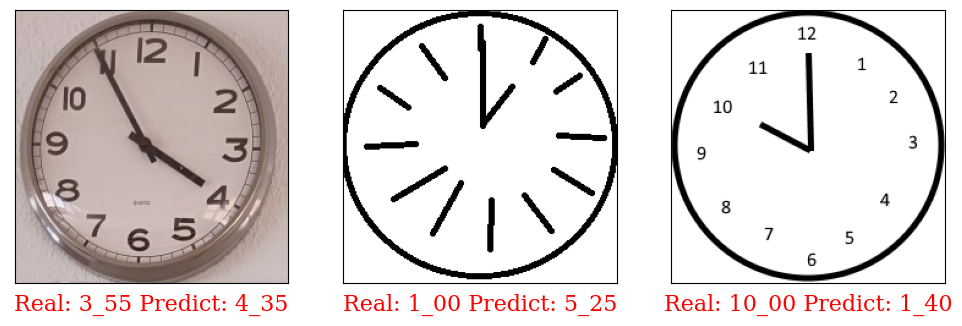

In [26]:
nrows = 1
ncols = 3

size = nrows * ncols

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

id = 2;

font_valid = {'family': 'serif',
              'color':  'green',
              'weight': 'normal',
              'size': 16,
              }

font_error = {'family': 'serif',
              'color':  'red',
              'weight': 'normal',
              'size': 16,
              }

for id in range(3):

    sp = plt.subplot(nrows, ncols, id + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mpimg.imread(real_images_full_dir[id])
    plt.imshow(img)

    res = model.predict(real_images[id:(id+1)]).argmax(axis=1)[0]
    prediction_hour = hours_dict[res]

    label = hours_dict[real_labels[id]]

    font = {}
    if (prediction_hour == label):
        font = font_valid
    else:
        font = font_error


    plt.xlabel("Real: " + str(label) + " Predict: " + prediction_hour, font)

plt.show()